# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc2'

In [3]:
pt.__version__

'0.7.4'

# Loading data

In [4]:
import cifar10
from cifar10 import img_size, num_channels
img_size_cropped = 24

In [5]:
cifar10.maybe_download_and_extract()

Data has been already downloaded and unpacked


In [6]:
class_names = cifar10.load_class_names()
num_classes = len(class_names)
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [8]:
images_test, cls_test, labels_test = cifar10.load_test_data()
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Size of:
- Training-set:		50000
- Test-set:		10000


In [9]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    # some sanity checks on inputs
    assert len(images) == len(cls_true)
    if cls_pred is not None:
        assert len(images) == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(len(images))))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    hspace = 0.3 if cls_pred is None else 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # smoothing
    interpolation = 'spline16' if smooth else 'nearest'

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, :], interpolation=interpolation)
        
        cls_true_name = class_names[cls_true[i]]
        
        if cls_pred is not None:
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = 'True: {0}\nPred: {1}'.format(cls_true_name, cls_pred_name)
        else:
            xlabel = 'True: {0}'.format(cls_true_name)
        
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

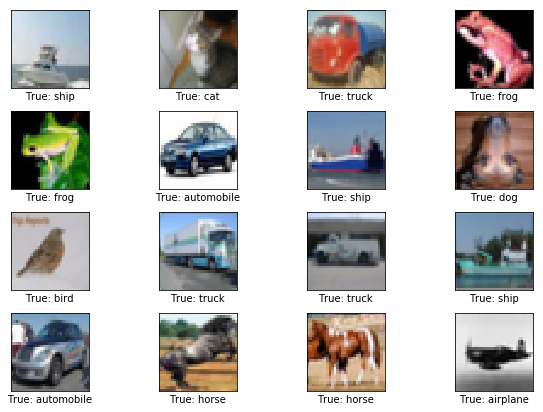

In [10]:
plot_images(images_train[100:116], cls_train[100:116], smooth=False)

# Tensorflow graph

## Placeholder variables

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

## Helper function for creating pre-processing flow

In [12]:
# TODO: try to run it without pre-processing
def pre_process_image(image, training):
    if training:
        # randomly crop and flip the image
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        image = tf.image.random_flip_left_right(image)
        
        # randomly adjust hue, contrast & saturation
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    return images

In [13]:
distorted_images = pre_process(images=x, training=True)

## Helper function function for creating main processing flow

In [14]:
def main_network(images, training):
    x_pretty = pt.wrap(images)
    
    phase = pt.Phase.train if training else pt.Phase.infer
    
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='fc1').\
            fully_connected(size=128, name='fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)
    
    return y_pred, loss

def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        images = x

        # create tf graph for pre-processing
        images = pre_process(images=images, training=training)

        # create tf graph for the main processing
        y_pred, loss = main_network(images=images, training=training)
        
    return y_pred, loss

## Create Neural Network for Training Phase

In [15]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
_, loss = create_network(training=True)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

## Create Neural Network for Test Phase

In [16]:
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Saver

In [17]:
saver = tf.train.Saver()

## Getting the weights

In [18]:
def get_weights_variable(layer_name):
    with tf.variable_scope('network/' + layer_name, reuse=True):
        variable = tf.get_variable('weights')
    return variable

weights_conv1 = get_weights_variable(layer_name='conv1')
weights_conv2 = get_weights_variable(layer_name='conv2')
#weights_conv3 = get_weights_variable(layer_name='conv3')

## Getting the layer outputs

In [19]:
def get_layer_output(layer_name):
    tensor_name = 'network/' + layer_name + '/Relu:0'
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)
    return tensor

output_conv1 = get_layer_output(layer_name='conv1')
output_conv2 = get_layer_output(layer_name='conv2')
#output_conv3 = get_layer_output(layer_name='conv3')

# TensorFlow Run
## Create TensorFlow Session

In [20]:
session = tf.Session()

## Restore or initialize variables

In [21]:
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'cifar10.cnn')

try:
    print('Trying to restore last checkpoint...')
    
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    
    print('Restored checkpoint from: ', last_chk_path)

except:
    print('Failed to restore checkpoint, initializing variables instead')
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10.cnn-78200
Restored checkpoint from:  checkpoints/cifar10.cnn-78200


## Helper function to get a random training batch

In [22]:
# generate random permutation of all images and return it in batches
def random_batch(train_batch_size=64):
    num_images = len(images_train)
    perm = np.random.permutation(num_images)
    i = 0
    
    while i < num_images:
        bs = np.min([train_batch_size, num_images - i])
        idx = perm[i:(i + bs)]
        i += bs
        yield images_train[idx, :, :, :], labels_train[idx, :]

## Helper function to plot example errors

In [23]:
def plot_example_errors(cls_pred, correct, n_images=16):
    incorrect = (correct == False)
    
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:n_images],
                cls_true=cls_true[0:n_images],
                cls_pred=cls_pred[0:n_images])

## Helper function to plot confusion matrix

In [24]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)
    
    for i in range(num_classes):
        class_name = '({}) {}'.format(i, class_names[i])
        print(cm[i, :], class_name)
    
    class_numbers = [' ({0})'.format(i) for i in range(num_classes)]
    print(''.join(class_numbers))
    
    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

## Helper function for calculating classifications

In [25]:
batch_size = 256

def predict_cls(images, labels, cls_true):
    num_images = len(images)
    
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0
    
    while i < num_images:
        j = min(i + batch_size, num_images)

        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        i = j
    
    correct = (cls_true == cls_pred)
    
    return correct, cls_pred

# predicted class for the test set
def predict_cls_test():
    return predict_cls(images=images_test, labels=labels_test, cls_true=cls_test)

# classification accuracy
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

## Helper function for showing the performance

In [26]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)
    
    print('Accuracy on test set: {0:.1%} ({1} / {2})'.format(acc, num_correct, num_images))
    
    if show_example_errors:
        print('Example errors:')
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    
    if show_confusion_matrix:
        print('Confusion matrix:')
        plot_confusion_matrix(cls_pred=cls_pred)

    return acc

## Helper function for plotting convolutional weights

In [27]:
def plot_conv_weights(weights, input_channel=0):
    # retrieve values of weights
    w = session.run(weights)
    
    print('Min:  {0:.5f}, Max:   {1:.5f}'.format(w.min(), w.max()))
    print('Mean: {0:.5f}, Stdev: {1:.5f}'.format(w.mean(), w.std()))
    
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))
    
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Helper function for plotting the output of convolutional layers

In [28]:
def plot_layer_output(layer_output, image):
    # retrieve the output of the layer
    values = session.run(layer_output, feed_dict={x: [image]})
    
    values_min = np.min(values)
    values_max = np.max(values)
    
    num_images = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_images))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = values[0, :, :, i]
            
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

## Examples of distorted images

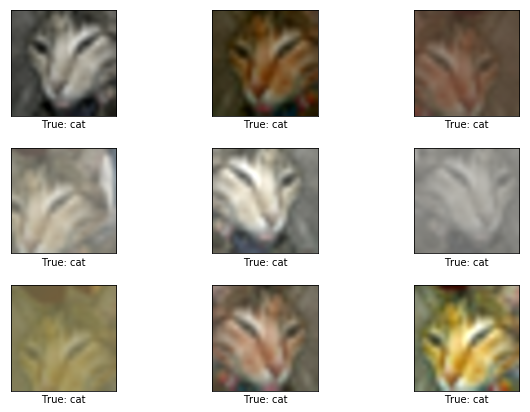

In [29]:
def plot_distorted_image(image, cls_true):
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)
    
    result = session.run(distorted_images, feed_dict={x: image_duplicates})
    
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

img, cls = get_test_image(256)
plot_distorted_image(img, cls)

## Helper function to perform optimization

In [30]:
def optimize(num_iterations):
    start_time = time.time()
    
    learning_acc = []

    # every iteration randomly goes through all images in the training set
    for i in range(num_iterations):
        for x_batch, y_true_batch in random_batch():
            feed_dict_train = {x: x_batch, y_true: y_true_batch}

            # run the optimizer
            i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)

            # print status every 100 iterations
            if i_global % 500 == 0:
                # calculate accuracy of the training batch
                batch_acc = session.run(accuracy, feed_dict=feed_dict_train)

                print('Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}'.format(i_global, batch_acc))

            if (i_global % 1000 == 0) or (i == num_iterations - 1):
                saver.save(session, save_path=save_path, global_step=global_step)

        # print accuracy after every full iteration
        acc = print_test_accuracy()
        learning_acc.append(acc)
    
    end_time = time.time()
    time_diff = end_time - start_time
    
    print('Time elapsed: ' + str(timedelta(seconds=int(round(time_diff)))))
    
    return learning_acc

## Perform optimization

In [31]:
# it's time consuming on my stunted laptop, hence false
if False:
    learning_acc = optimize(num_iterations=50)

    # plot learning accuracy
    plt.plot(learning_acc)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

## Results

Accuracy on test set: 77.9% (7790 / 10000)
Example errors:


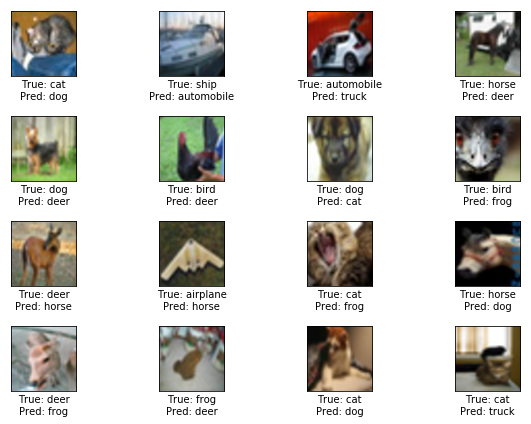

Confusion matrix:
[786  27  31  12  17  10  13  14  41  49] (0) airplane
[  7 909   5   4   1   7   2   4  10  51] (1) automobile
[ 55   9 637  35  68  80  53  46   8   9] (2) bird
[ 21  17  46 515  48 204  59  58   9  23] (3) cat
[ 15   2  29  38 738  50  41  73   8   6] (4) deer
[  6   6  18  99  28 759  22  48   7   7] (5) dog
[  8   5  11  37  20  25 875  10   1   8] (6) frog
[  3   3   7  24  41  53   7 849   2  11] (7) horse
[ 40  42   9   9  10   5   5   7 835  38] (8) ship
[ 10  59   2   7   3   4   6  11  11 887] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


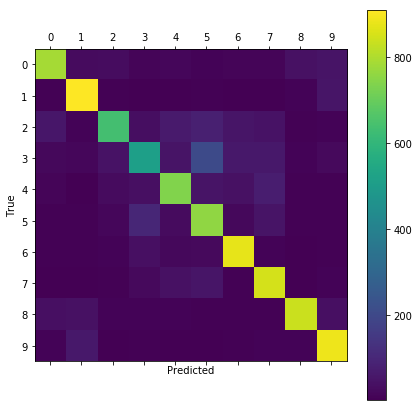

0.77900000000000003

In [32]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Convolutional weights

Min:  -0.59169, Max:   0.66575
Mean: -0.00021, Stdev: 0.16316


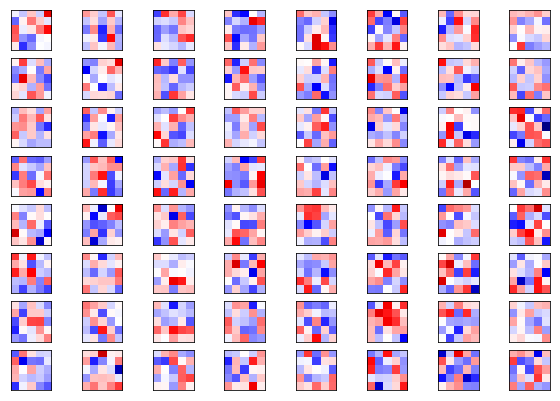

In [33]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -0.46758, Max:   0.23013
Mean: -0.00296, Stdev: 0.04668


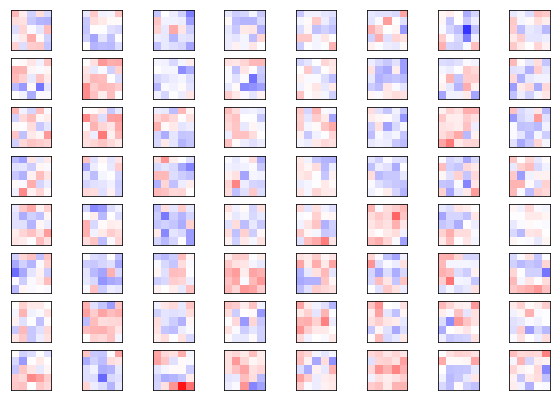

In [34]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

In [35]:
#plot_conv_weights(weights=weights_conv3, input_channel=1)

## Getting the weights of fully-connected layers

In [36]:
weights_fc1 = get_weights_variable(layer_name='fc1')
weights_fc2 = get_weights_variable(layer_name='fc2')

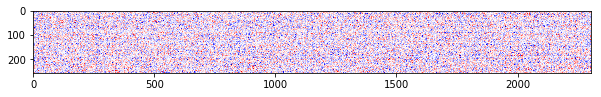

In [37]:
# FC1
w = session.run(weights_fc1)
w_min, w_max = np.min(w), np.max(w)
abs_max = max(abs(w_min), abs(w_max))
plt.imshow(w.T, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap='seismic')
plt.show()

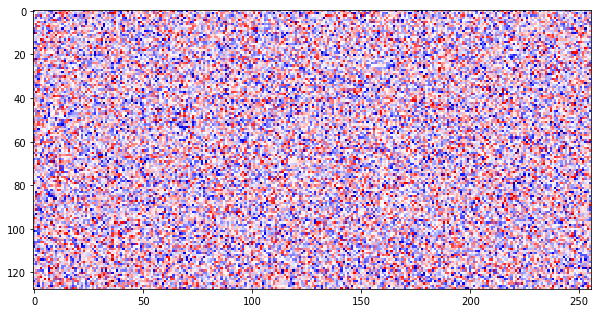

In [38]:
# FC2
w = session.run(weights_fc2)
w_min, w_max = np.min(w), np.max(w)
abs_max = max(abs(w_min), abs(w_max))
plt.imshow(w.T, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap='seismic')
plt.show()

## Output of convolutional layers

In [39]:
def plot_image(image):
    fig, axes = plt.subplots(1, 2)
    
    ax0 = axes.flat[0]
    ax0.imshow(image, interpolation='nearest')
    ax0.set_xlabel('Raw')

    ax1 = axes.flat[1]
    ax1.imshow(image, interpolation='spline16')
    ax1.set_xlabel('Smooth')
    
    plt.show()

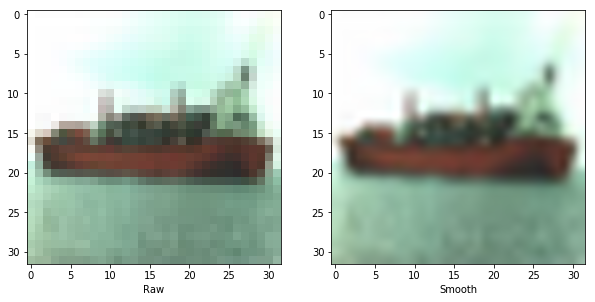

In [40]:
img, cls = get_test_image(1891)
plot_image(img)

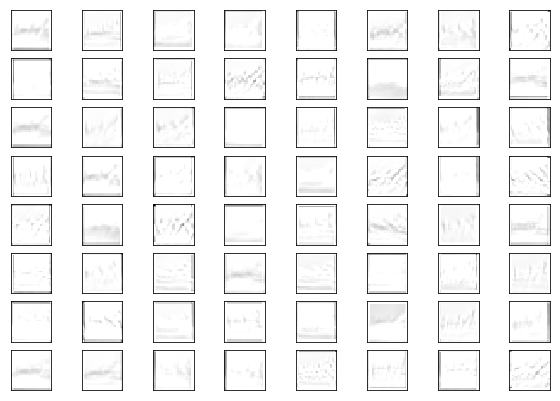

In [41]:
plot_layer_output(output_conv1, image=img)

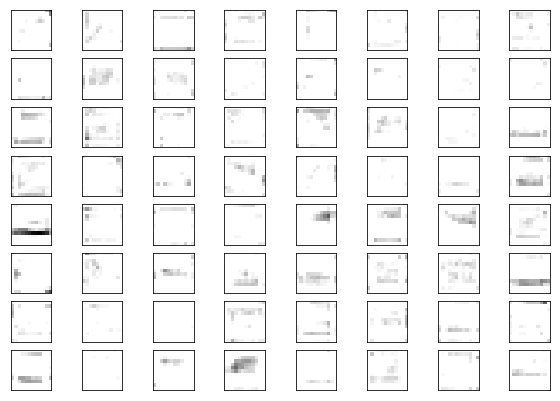

In [42]:
plot_layer_output(output_conv2, image=img)

In [43]:
#plot_layer_output(output_conv3, image=img)

## Predicted class-labels

In [44]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls], feed_dict = {x: [img]})
np.set_printoptions(precision=3, suppress=True)
print(label_pred[0])
print('Predicted label: ' + class_names[np.argmax(label_pred[0])])

[ 0.     0.     0.     0.     0.     0.     0.     0.     0.999  0.001]
Predicted label: ship
